<a href="https://colab.research.google.com/github/Ikeda33/codespaces-railstutorial/blob/main/vit2_50epoch_flower_D_v_G_sa_FID_KID_devide_1_color_relativistic1_hinge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#パッケージのダウンロード


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import argparse

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim

In [5]:
import torchvision.transforms as transforms

In [6]:
import torchvision.datasets as dset

In [7]:
import torchvision.utils as vutils

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import tqdm

In [9]:
import glob

In [10]:
from torch.utils.data import Dataset
from PIL import Image

In [11]:
from torch.utils.data import DataLoader
import torchvision

In [12]:
!pip install torchmetrics
!pip install torchmetrics[image]

!pip install torch-fidelity

from torchmetrics.image.inception import InceptionScore


import torchmetrics
import torch_fidelity

import torch
_ = torch.manual_seed(123)
from torchmetrics.image.fid import FrechetInceptionDistance
fid = FrechetInceptionDistance(feature=2048)

from torchmetrics.image.kid import KernelInceptionDistance


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 13.2 MB/s eta 0:00:00


Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 387MB/s]


In [13]:
kid = KernelInceptionDistance(subset_size=15)

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `Kernel Inception Distance` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028


In [14]:
#ハイパーパラメータの設定

In [15]:
parser = argparse.ArgumentParser()
parser.add_argument("--n_epoch", type = int, default=50)
parser.add_argument("--batch_size", type = int, default=32)
parser.add_argument("--lr_g", type = float, default=2e-4)
parser.add_argument("--lr_d", type = float, default=3e-4)
parser.add_argument("--nch_g", type = int, default=64)
parser.add_argument("--nch_d", type = int, default=64)
parser.add_argument("--z_dim", type = int, default=100)
parser.add_argument("--beta1", type = float, default=0.5)

opt = parser.parse_args(args=[])
print(opt)

Namespace(n_epoch=50, batch_size=32, lr_g=0.0002, lr_d=0.0003, nch_g=64, nch_d=64, z_dim=100, beta1=0.5)


In [16]:
class ImageDataset(Dataset):
    def __init__(self,  transform = None):
        super().__init__()
        self.file_list = glob.glob("/content/drive/MyDrive/102flowers (2)/jpg/*.jpg")#/content/drive/MyDrive/img_align_celeba.zip
        #self.file_list = glob.glob("/content/drive/MyDrive/cityscapes/cityscapes_data/train/*.jpg" )#/content/drive/MyDrive/cityscapes/cityscapes_data/train
        #self.file_list = glob.glob("/content/drive/MyDrive/Test/**/*.jpg" )#fruits
       # self.file_list = glob.glob("/content/drive/MyDrive/img_align_celeba.zip/jpg/*.jpg")#C:\Users\ikeda\Downloads\img_align_celeba\img_align_celeba
        #self.file_list = glob.glob("/content/drive/MyDrive/–¢Šm”F 758452(1).crdownload/*.jpg")
        self.transform = transform


    def __getitem__(self, index):
        if self.transform is not None:
            img = self.transform(Image.open(self.file_list[index]))
        else:
            img = Image.open(self.file_list[index])
        return img

    def __len__(self):
        return len(self.file_list)

In [17]:
from torchvision.transforms.transforms import CenterCrop

transform = transforms.Compose([

    transforms.Resize(80),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
                               transforms.Normalize((0.5,),(0.5,))])

In [18]:
#dataset = dset.MNIST("./", train = True, download = True,transform = transform)
dataset = ImageDataset(transform = transform)
#dataset = torchvision.datasets.CelebA("./", split = "test", download = True,transform = transform) #Cityscapes
#dataset = torchvision.datasets.Cityscapes("C:\Users\ikeda\Downloads\cityscapes\cityscapes_data\cityscapes_data", split='train', mode='fine', target_type='color')


In [19]:
dataloader = DataLoader(dataset = dataset, batch_size = opt.batch_size,num_workers = 2,  shuffle = True)

In [20]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


In [21]:
#モデルの設定

In [22]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        out_channels = in_channels
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.se_block_0 = SE(out_channels)
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x

    def forward(self, x):
        identity = x#入力
        x = self.conv1(x)
        x = self.se_block_0(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.se_block_0(x)
        x = self.bn(x)
        x = x + self.shortcut(identity)
        return x

In [23]:
class ResidualBlock_G(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        out_channels = in_channels
        self.conv1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv2 = nn.utils.spectral_norm(nn.ConvTranspose2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.se_block_0 = SE_G(out_channels)
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x

    def forward(self, x):
        identity = x#入力
        x = self.conv1(x)
        x = self.se_block_0(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.se_block_0(x)
        x = self.bn(x)
        x = x + self.shortcut(identity)
        return x

In [24]:
class ResidualBlock_1(nn.Module):#実質パディングとスペクトラム正規化とインスタンス正規化
  def __init__(self, in_channels):
    super().__init__()
    self.conv_layers = nn.Sequential(
        nn.ReflectionPad2d(1),
        nn.utils.spectral_norm(nn.Conv2d(in_channels, in_channels, 3)),
        nn.InstanceNorm2d(in_channels),
        nn.ReLU(inplace = True),

        nn.ReflectionPad2d(1),
        nn.utils.spectral_norm(nn.Conv2d(in_channels, in_channels, 3)),
        nn.InstanceNorm2d(in_channels),

    )
  def forward(self, x):
    out = self.conv_layers(x)
    out = out + x
    return out

In [25]:
class SelfAttention(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        n_divide = in_channels
        #out_channels = in_channels // n_divide
        out_channels = 1

        self.fx_1x1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm
        self.gx_1x1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels, kernel_size = 1))#
        self.hx_1x1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, in_channels, kernel_size = 1))#
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2


    def forward(self, x):
        B, C, H, W = x.size()
        #x = nn.LayerNorm([C,H,W])#input.size()[1:]
        fx = self.fx_1x1(x).view(B, -1, H*W).permute(0,2,1)
        gx = self.gx_1x1(x).view(B, -1, H*W)
        hx = self.hx_1x1(x).view(B, -1, H*W)

        s_mtx = torch.bmm(fx, gx)
        attention = self.softmax(s_mtx)

        o =torch.bmm(hx, attention)
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o
        return out

In [26]:
#import torch
#from layers.transformer.ScaledDotProductAttention import ScaledDotProductAttention
#from torch import nn


class MultiHeadAttention(nn.Module):
    def __init__(self, in_channels, h = 8):
        super().__init__()
        d_model = in_channels
        self.d_model = in_channels
        self.h = in_channels
        self.d_k = d_model // h
        self.d_v = d_model // h
        self.fx_1x1 = (nn.Conv2d(in_channels, in_channels//self.h, kernel_size = 1))
        self.gx_1x1 = (nn.Conv2d(in_channels, in_channels//self.h, kernel_size = 1))
        self.hx_1x1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, in_channels, kernel_size = 1))
        self.qkv = nn.utils.spectral_norm(nn.Conv2d(in_channels, 3 * in_channels, kernel_size = 1))

#        self.scaled_dot_product_attention = SelfAttention(self.d_model)

        self.linear = nn.Linear(self.h * self.d_v, d_model)
       # self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm
        #self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#
        #self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2

        self.se_block_0 = SE(in_channels)
        self.relu = nn.ReLU()

    def forward(self, x ) -> torch.Tensor:
        B, C, H, W = x.size()
        qkv = self.qkv(x)
        self.q, self.k, self.v = qkv.chunk(3, dim = 1)

        #self.q = self.se_block_0(self.q)
        #self.k = self.se_block_0(self.k)
        #self.v = self.se_block_0(self.v)

        """Scaled dot product attention"""
       # attention_output = self.scaled_dot_product_attention(self.q, self.k, self.v)  # (head*batch_size, seq_len, d_model)
        B, C, H, W = self.q.size()
        #x = nn.LayerNorm([C,H,W])#input.size()[1:]
        fx = self.fx_1x1(self.q).view(B, -1, H*W).permute(0,2,1)
        gx = self.gx_1x1(self.k).view(B, -1, H*W)
        hx = self.hx_1x1(self.v).view(B, -1, H*W)
       # fx = self.q.view(B, -1, H*W).permute(0,2,1)
       # gx = self.k.view(B, -1, H*W)
       # hx = self.v.view(B, -1, H*W)

        s_mtx = torch.bmm(fx, gx)
        attention = self.softmax(s_mtx)

        o =torch.bmm(hx, attention)
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o

        #out = out.repeat(1,self.h*1,1,1)

        #out = torch.chunk(out, self.h, dim=1)
       # out = torch.cat(out, dim=1)

        """Linear after scaled dot product attention"""
        #output = self.linear(out)
        return out


In [27]:

class MultiHeadAttention_G(nn.Module):
    def __init__(self, in_channels, h = 8):
        super().__init__()
        d_model = in_channels
        self.d_model = in_channels
        self.h = in_channels
        self.d_k = d_model // h
        self.d_v = d_model // h
        self.fx_1x1 = (nn.ConvTranspose2d(in_channels, in_channels//self.h, kernel_size = 1))
        self.gx_1x1 = (nn.ConvTranspose2d(in_channels, in_channels//self.h, kernel_size = 1))
        self.hx_1x1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, in_channels, kernel_size = 1))
        self.qkv = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, 3 * in_channels, kernel_size = 1))

#        self.scaled_dot_product_attention = SelfAttention(self.d_model)

        self.linear = nn.Linear(self.h * self.d_v, d_model)
       # self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm
        #self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#
        #self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2

        self.se_block_0 = SE_G(in_channels)
        self.relu = nn.ReLU()

    def forward(self, x ) -> torch.Tensor:
        B, C, H, W = x.size()
        qkv = self.qkv(x)
        qkv = self.relu(qkv)
        self.q, self.k, self.v = qkv.chunk(3, dim = 1)

        #self.q = self.se_block_0(self.q)
        #self.k = self.se_block_0(self.k)
        #self.v = self.se_block_0(self.v)
        """Scaled dot product attention"""
       # attention_output = self.scaled_dot_product_attention(self.q, self.k, self.v)  # (head*batch_size, seq_len, d_model)
        B, C, H, W = self.q.size()
        #x = nn.LayerNorm([C,H,W])#input.size()[1:]
        fx = self.fx_1x1(self.q).view(B, -1, H*W).permute(0,2,1)
        gx = self.gx_1x1(self.k).view(B, -1, H*W)
        hx = self.hx_1x1(self.v).view(B, -1, H*W)
       # fx = self.q.view(B, -1, H*W).permute(0,2,1)
       # gx = self.k.view(B, -1, H*W)
       # hx = self.v.view(B, -1, H*W)

        s_mtx = torch.bmm(fx, gx)
        attention = self.softmax(s_mtx)

        o =torch.bmm(hx, attention)
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o

        #out = out.repeat(1,self.h*1,1,1)

        #out = torch.chunk(out, self.h, dim=1)
       # out = torch.cat(out, dim=1)

        """Linear after scaled dot product attention"""
        #output = self.linear(out)
        return out

In [28]:
class SelfAttention_G(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        n_divide = in_channels
        out_channels = in_channels // n_divide
      #  out_channels = 1

        self.fx_1x1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels, kernel_size = 1))
        self.gx_1x1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels, kernel_size = 1))
        self.hx_1x1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, in_channels, kernel_size = 1))
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2


    def forward(self, x):
        B, C, H, W = x.size()
        fx = self.fx_1x1(x).view(B, -1, H*W).permute(0,2,1)
        gx = self.gx_1x1(x).view(B, -1, H*W)
        hx = self.hx_1x1(x).view(B, -1, H*W)

        s_mtx = torch.bmm(fx, gx)
        attention = self.softmax(s_mtx)

        o =torch.bmm(hx, attention)
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o
        return out

In [29]:
class PF(nn.Module):#poolformer
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))#kernel_size=4, stride=2, padding=1
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.pre_bn = nn.BatchNorm2d(in_channels)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size = 3, stride = 1, padding = 3//2, count_include_pad=False)
        self.flat = nn.Flatten()
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x

    def forward(self, x):
        identity = x#入力
        x = self.pre_bn(x)
        x = self.pool(x) -x
        x = x + identity

        identity = x#入力
        x = self.pre_bn(x)
        x= self.flat(x)
        x = self.conv1(x)
        x = self.relu(x)
        x = x + self.shortcut(identity)
        return x

In [30]:
"""    def __init__(self, in_channels):
        super().__init__()
        n_divide = 8
        out_channels = in_channels // n_divide
        self.dim = 3

        self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm
        self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#
        self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))#kernel_size=4, stride=2, padding=1
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size==1 -> チャネル数だけ変化させること
        self.pre_bn = nn.BatchNorm2d(in_channels)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.pool= nn.AvgPool2d(kernel_size =self.dim , stride = 1, padding = 0, count_include_pad=False)
        self.sigmoid = nn.Sigmoid()


    def forward(self, x):
        B, C, H, W = x.size()
        z = self.pre_bn(x)
        z = self.pool(z, self.dim = H)

        z = self.conv1(z)
        z = self.relu(z)

        z = self.conv2(z)
        z = self.sigmoid(z)

        z = torch.einsum("bchw,bchw->bchw",(x, z))
        out = x + self.gamma * z
        return out
"""

'    def __init__(self, in_channels):\n        super().__init__()\n        n_divide = 8\n        out_channels = in_channels // n_divide\n        self.dim = 3\n\n        self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm\n        self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#\n        self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#\n        self.gamma = nn.Parameter(torch.zeros(1))\n        self.softmax = nn.Softmax(dim = -2)#規格化するため -2\n        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))#kernel_size=4, stride=2, padding=1\n        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))\n        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size==1 -> チャネル数だけ変化させること\n        self.pre_bn = nn.BatchNorm2d(in_channels)\n        self.bn = n

In [31]:
class SE(nn.Module):#SE_Block layerに対して作用するattentionのようなモデル
    def __init__(self, in_channels, reduction=24):
        super().__init__()
        channel = in_channels
        reduction = in_channels
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
           # nn.Linear(channel, channel// reduction , bias=False),
            (nn.Conv2d(in_channels, in_channels// reduction,kernel_size = 1, padding = 0)),
            nn.ReLU(inplace=True),
            #nn.Linear(channel // reduction, channel, bias=False),
            (nn.Conv2d(in_channels// reduction,in_channels,kernel_size = 1, padding = 0)),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        #y = self.avg_pool(x).view(b, c)
        y = self.avg_pool(x)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)




In [32]:
class SE_G(nn.Module):#SE_Block layerに対して作用するattentionのようなモデル
    def __init__(self, in_channels, reduction=24):
        super().__init__()
        channel = in_channels
        reduction = in_channels
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            #nn.Linear(channel, channel// reduction , bias=False),
            nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, in_channels// reduction,kernel_size = 1, padding = 0)),
            nn.ReLU(inplace=True),
            #nn.Linear(channel // reduction, channel, bias=False),
            nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels// reduction,in_channels,kernel_size = 1, padding = 0)),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

In [33]:
#nn.ConvTranspose2d
class PF_G(nn.Module):#poolformer
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size=3, padding=1))
        self.conv2 = nn.utils.spectral_norm(nn.ConvTranspose2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.pre_bn = nn.BatchNorm2d(in_channels)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size = 3, stride = 1, padding = 3//2, count_include_pad=False)
        self.flat = nn.Flatten()
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x

    def forward(self, x):
        identity = x#入力
        x = self.pre_bn(x)
        x = self.pool(x) - x
        x = x + identity

        identity = x#入力
        x = self.pre_bn(x)
        x = self.flat(x)
        x = self.conv1(x)
        x = self.relu(x)
        x = x + self.shortcut(identity)
        return x

In [34]:
"""(((W - K + 2P)/S) + 1)
    Here W = Input size
    K = Filter size
    S = Stride
    P = Padding
    ((Input_size-kernel_size + 2*Padding)/stride)+ 1
    この式を使用できます[(W−K+2P)/S]+1。

W は入力ボリュームです - あなたの場合は 128
Kはカーネルサイズです - あなたの場合は5です
P はパディングです - あなたの場合は 0 だと思います
S はストライドです - あなたが提供していません。
したがって、次の式に入力します。
for example
Output_Shape = (128-5+0)/1+1

Output_Shape = (124,124,40)
output==1 ,1  = (W - k + 2p)/s = 0   s = 1, p = 0 ,k = W
    """



'(((W - K + 2P)/S) + 1)\n    Here W = Input size\n    K = Filter size\n    S = Stride\n    P = Padding\n    ((Input_size-kernel_size + 2*Padding)/stride)+ 1\n    この式を使用できます[(W−K+2P)/S]+1。\n\nW は入力ボリュームです - あなたの場合は 128\nKはカーネルサイズです - あなたの場合は5です\nP はパディングです - あなたの場合は 0 だと思います\nS はストライドです - あなたが提供していません。\nしたがって、次の式に入力します。\nfor example\nOutput_Shape = (128-5+0)/1+1\n\nOutput_Shape = (124,124,40)\noutput==1 ,1  = (W - k + 2p)/s = 0   s = 1, p = 0 ,k = W\n    '

In [35]:
class VIT(nn.Module):
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.bn = nn.BatchNorm2d(out_channels)
        self.pre_bn = nn.BatchNorm2d(in_channels)

        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size = 3, stride = 1, padding = 3//2)
        self.attention = SelfAttention(in_channels)
        self.se_block_0 = SE(in_channels)
        self.se_block_1 = SE(out_channels)

        self.flat = nn.Flatten()

        self.linear_1 = nn.Linear(32,64, bias=False)
        self.linear_2 = nn.Linear( 32,32, bias=False)#if ( 64,32, bias=False)  -> mat1 and mat2 shapes cannot be multiplied (131072x32 and 64x32)


    def shortcut(self, x):
        x = self.conv3(x)
        #x = self.se_block_1(x)
        x = self.bn(x)
        return x

    def forward(self, x):

        identity = x#入力
        x = self.pre_bn(x)
       # x = self.se_block_0(x)
        x = self.attention(x) - x
        x = x + identity


        identity = x#入力
        x = self.pre_bn(x)
       # b, c, h, w = x.size()
        x = self.conv1(x)


      #  x = self.linear_1(x).view(b, -1, h, w)
        x = self.relu(x)
       # x = self.linear_2(x).view(b, -1, h, w)


        x =  self.shortcut(identity) + x
        #x = x + self.shortcut(identity)
        x = self.bn(x)

        return x

In [36]:
#nn.ConvTranspose2d
class VIT_G(nn.Module):
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size=3, padding=1))
        self.conv2 = nn.utils.spectral_norm(nn.ConvTranspose2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size=1 -> チャネル数だけ変化させること
        self.bn = nn.BatchNorm2d(out_channels)
        self.pre_bn = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size = 3, stride = 1, padding = 3//2, count_include_pad=False)
        self.attention = MultiHeadAttention_G(in_channels)

    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x

    def forward(self, x):
        identity = x#入力
        x = self.pre_bn(x)
        x = self.attention(x) - x
        x = x + identity

        #identity = x#入力
        x = self.pre_bn(x)
        x = self.conv1(x)
        x = self.relu(x)
        x = x + self.shortcut(identity)
        return x

In [37]:
class Generator(nn.Module):
    def __init__(self,pf, vit, resnet,res_net,sa,z_dim = opt.z_dim, ngf = opt.nch_g, nc = 3):# ものくろだからnc=1 カラーならnc=3
        super().__init__()

        self.convt1 = self.conv_trans_layers(z_dim, 8*ngf, 4,1,0 )# ngf = the number of channels

        self.convt2 = self.conv_trans_layers(8*ngf, 4*ngf, 4, 2, 1 )
        self.convt3 = self.conv_trans_layers(4*ngf,  2*ngf, 4,2,1)
        self.convt4 = self.conv_trans_layers(2*ngf,  ngf, 4,2,1 )

        self.pf1 = pf(z_dim, 8*ngf)
        self.vit1 = vit(z_dim, 8*ngf)

        self.pf2 = pf(8*ngf, 4*ngf)
        self.vit2 = vit(8*ngf, 4*ngf)

        self.pf3 = pf(4*ngf,  2*ngf)
        self.vit3 = vit(4*ngf,  2*ngf)

        self.pf4 = pf(2*ngf,  ngf)
        self.vit4 = vit(2*ngf,  ngf)

        self.convt5 = nn.Sequential(
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1),
            #self.conv_trans_layers(ngf, nc, 4,2,1  )
            nn.Tanh()
        )


    @staticmethod
    def conv_trans_layers(in_channels, out_channels, kernel_size, stride, padding, has_norm=True,attention=True, res_net= False, se = False):
        layers = [nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding))]#spectralnorm
        if has_norm:
            layers.append(nn.BatchNorm2d(out_channels))
        #layers.append(nn.ReLU(inplace = True))
        layers.append(nn.LeakyReLU(0.2, inplace = True))
        if se:
            layers.append(SE_G(out_channels))
        if attention:
            layers.append(SelfAttention_G(out_channels))
        if res_net:
            layers.append(ResidualBlock_G(out_channels))



        net = nn.Sequential(*layers)#listのアンパック

        return net

    def forward(self, x):
        out = self.convt1(x)

        out = self.convt2(out)

        out = self.convt3(out)

        out = self.convt4(out)

        out = self.convt5(out)


        return out

In [38]:
from pickle import FALSE
class Discriminator(nn.Module):
    def __init__(self,pf,vit ,resnet,res_net,sa,nc = 3, ndf = opt.nch_d):# ものくろだからnc=1 カラーならnc=3
        super().__init__()
        self.conv1 = self.conv_layers(nc, ndf)
        self.pf1 = pf(nc,ndf)
        self.vit1 = vit(nc,ndf)

        self.conv2 = self.conv_layers(ndf, 2*ndf )
        self.pf2 = pf(ndf, 2*ndf)
        self.vit2 = vit(ndf, 2*ndf)

        self.conv3 = self.conv_layers(2*ndf, 4*ndf )
        self.pf3 = pf(2*ndf, 4*ndf )
        self.vit3 = vit(2*ndf, 4*ndf )

        self.conv4 = self.conv_layers(4*ndf, 8*ndf)
        self.pf4 = pf(4*ndf, 8*ndf)
        self.vit4 = vit(4*ndf, 8*ndf)

        self.vit5 = vit(8*ndf, 16*ndf)

        self.conv5 =  nn.Conv2d(8*ndf, 1,  4)
        #self.conv6 =  nn.Conv2d(16*ndf, 1,  4)


    @staticmethod
    def conv_layers(in_channels, out_channels, kernel_size=4, stride=2, padding=1, has_batch_norm = True, attention = False, res_net = False, se = False):
        layers = [nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding))]
        if has_batch_norm:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2, inplace = True))
        if se:
            layers.append(SE(out_channels))
        if attention:
            layers.append(SelfAttention(out_channels))

        if res_net:
            layers.append(ResidualBlock(out_channels))


        net = nn.Sequential(*layers)#listのアンパック

        return net

    def forward(self, x):
        out = self.conv1(x)

        out = self.vit2(out)

        out = self.vit3(out)

        out = self.vit4(out)

        out = self.conv5(out)

        return out

In [39]:
#モデルのトレーニング

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [41]:
device

device(type='cuda')

In [42]:
netG = Generator(PF_G,VIT_G,ResidualBlock,ResidualBlock_1,SelfAttention, z_dim=opt.z_dim , ngf=opt.nch_g ).to(device)
netG.apply(weights_init)
print(netG)

netD = Discriminator(PF,VIT,ResidualBlock,ResidualBlock_1,SelfAttention, nc = 3 , ndf=opt.nch_d ).to(device)# ものくろだからnc=1 カラーならnc=3
netD.apply(weights_init)
print(netD)

Generator(
  (convt1): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): SelfAttention_G(
      (fx_1x1): ConvTranspose2d(512, 1, kernel_size=(1, 1), stride=(1, 1))
      (gx_1x1): ConvTranspose2d(512, 1, kernel_size=(1, 1), stride=(1, 1))
      (hx_1x1): ConvTranspose2d(512, 512, kernel_size=(1, 1), stride=(1, 1))
      (softmax): Softmax(dim=-2)
    )
  )
  (convt2): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): SelfAttention_G(
      (fx_1x1): ConvTranspose2d(256, 1, kernel_size=(1, 1), stride=(1, 1))
      (gx_1x1): ConvTranspose2d(256, 1, kernel_size=(1, 1), stride=(1, 1))
      (hx_1x1): ConvTranspo

In [43]:
#criterion = nn.BCELoss()
#criterion = torch.nn.HingeEmbeddingLoss()
optimizerG = optim.Adam(netG.parameters(), lr = opt.lr_g, betas= (opt.beta1, 0.999), weight_decay = 1e-5)
optimizerD = optim.Adam(netD.parameters(), lr = opt.lr_d, betas= (opt.beta1, 0.999), weight_decay = 1e-5)

100%|██████████| 103/103 [02:06<00:00,  1.23s/it]


epoch: 0, lossD:1.356497504757446, lossG:4.325482000425024,lossG_fake:2.008867660772453, lossG_real:2.3166143408099424 ,equality:-0.3077466800374893


evaluate:156.6758270263672,kid_mean:0.12919659912586212, kid_std:0.020607225596904755,kid_:(tensor(0.1292), tensor(0.0206))


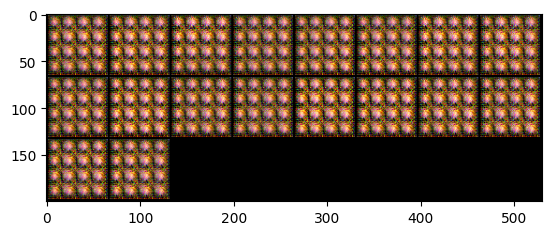

100%|██████████| 103/103 [01:01<00:00,  1.68it/s]


epoch: 1, lossD:1.325138950810849, lossG:3.6633220436503584,lossG_fake:2.050336899109257, lossG_real:1.6129851491705884 ,equality:0.43735174993866854


evaluate:125.95030975341797,kid_mean:0.0694228857755661, kid_std:0.028043536469340324,kid_:(tensor(0.0694), tensor(0.0280))


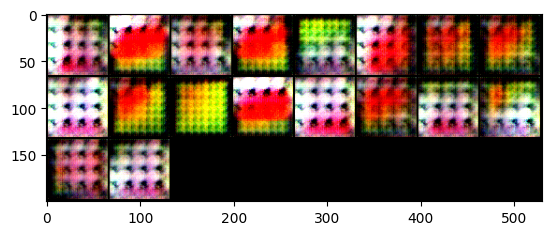

100%|██████████| 103/103 [01:01<00:00,  1.68it/s]


epoch: 2, lossD:1.7080639959539023, lossG:2.654915902221087,lossG_fake:1.4603024779014218, lossG_real:1.1946134225836078 ,equality:0.26568905531781395


evaluate:116.25691986083984,kid_mean:0.06966443359851837, kid_std:0.030677972361445427,kid_:(tensor(0.0697), tensor(0.0307))


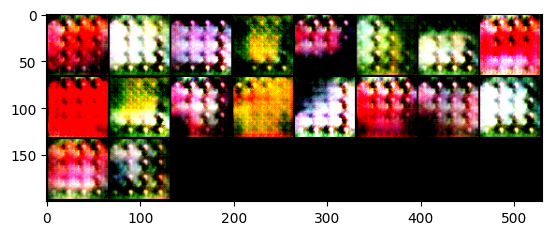

100%|██████████| 103/103 [01:01<00:00,  1.69it/s]


epoch: 3, lossD:1.76150711531778, lossG:2.564265369211586,lossG_fake:1.3846045292696907, lossG_real:1.1796608486221831 ,equality:0.20494368064750756


evaluate:108.83399963378906,kid_mean:0.06170818209648132, kid_std:0.033272042870521545,kid_:(tensor(0.0617), tensor(0.0333))


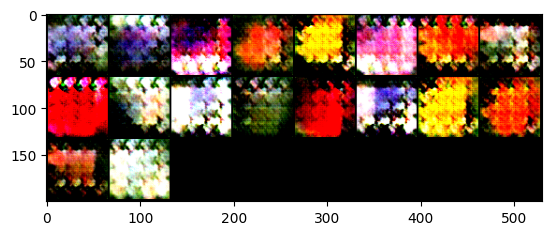

100%|██████████| 103/103 [01:01<00:00,  1.68it/s]


epoch: 4, lossD:1.7995713243206728, lossG:2.455166756528095,lossG_fake:1.3434019308645748, lossG_real:1.1117648216127192 ,equality:0.23163710925185566


evaluate:115.01509857177734,kid_mean:0.0639180839061737, kid_std:0.030884137377142906,kid_:(tensor(0.0639), tensor(0.0309))


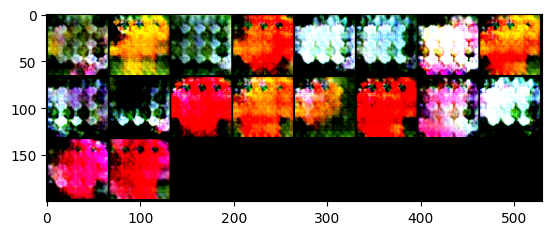

100%|██████████| 103/103 [01:01<00:00,  1.68it/s]


epoch: 5, lossD:1.8083843143240919, lossG:2.4854142364946386,lossG_fake:1.3415654550478295, lossG_real:1.143848771030463 ,equality:0.19771668401736653


evaluate:110.7439193725586,kid_mean:0.06606273353099823, kid_std:0.031093569472432137,kid_:(tensor(0.0661), tensor(0.0311))


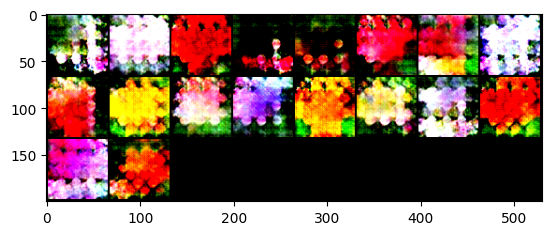

100%|██████████| 103/103 [01:01<00:00,  1.68it/s]


epoch: 6, lossD:1.7958106520106492, lossG:2.4986617588302464,lossG_fake:1.3249032902486115, lossG_real:1.173758468002949 ,equality:0.1511448222456626


evaluate:116.08814239501953,kid_mean:0.07371760159730911, kid_std:0.0329168364405632,kid_:(tensor(0.0737), tensor(0.0329))


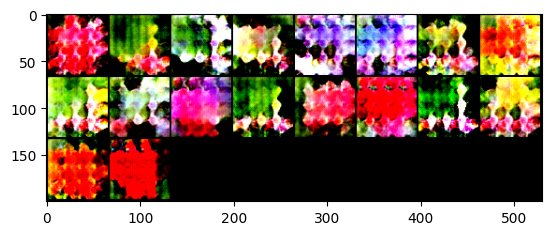

100%|██████████| 103/103 [01:01<00:00,  1.68it/s]


epoch: 7, lossD:1.796889066696167, lossG:2.543133145397149,lossG_fake:1.339793162438476, lossG_real:1.2033399812226158 ,equality:0.13645318121586025


evaluate:111.62973022460938,kid_mean:0.0659196674823761, kid_std:0.03527403995394707,kid_:(tensor(0.0659), tensor(0.0353))


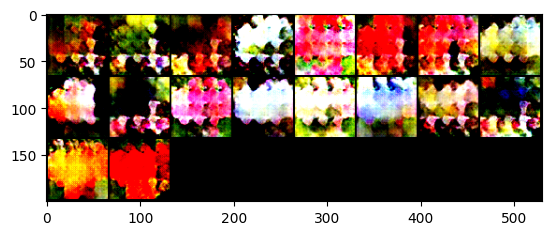

100%|██████████| 103/103 [01:01<00:00,  1.68it/s]


epoch: 8, lossD:1.770902909121467, lossG:2.534892626179075,lossG_fake:1.3351723499668455, lossG_real:1.199720295887549 ,equality:0.1354520540792965


evaluate:116.51791381835938,kid_mean:0.0688246414065361, kid_std:0.03697064518928528,kid_:(tensor(0.0688), tensor(0.0370))


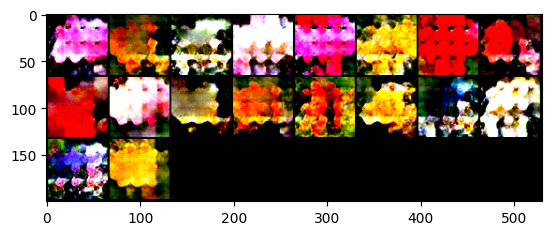

100%|██████████| 103/103 [01:01<00:00,  1.68it/s]


epoch: 9, lossD:1.7995972158839402, lossG:2.5150421036099924,lossG_fake:1.3229563826496162, lossG_real:1.1920857261685491 ,equality:0.1308706564810671


evaluate:118.82975006103516,kid_mean:0.0716618150472641, kid_std:0.04186424985527992,kid_:(tensor(0.0717), tensor(0.0419))


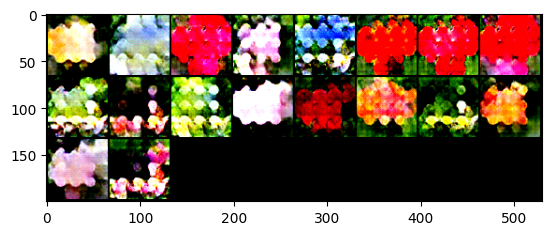

100%|██████████| 103/103 [01:01<00:00,  1.68it/s]


epoch: 10, lossD:1.7586420126331663, lossG:2.5729230075206573,lossG_fake:1.3559835107581129, lossG_real:1.2169394794019681 ,equality:0.13904403135614474


evaluate:124.05474090576172,kid_mean:0.0746658593416214, kid_std:0.04028051346540451,kid_:(tensor(0.0747), tensor(0.0403))


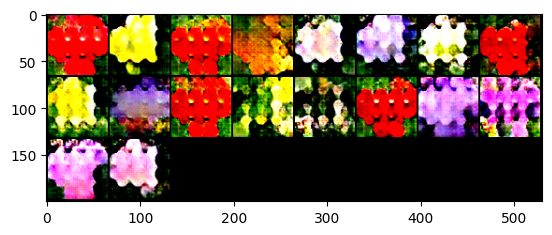

100%|██████████| 103/103 [01:01<00:00,  1.68it/s]


epoch: 11, lossD:1.765172086873101, lossG:2.596957604861954,lossG_fake:1.3618928633847283, lossG_real:1.2350647281674505 ,equality:0.12682813521727776


evaluate:122.71016693115234,kid_mean:0.08156589418649673, kid_std:0.036556437611579895,kid_:(tensor(0.0816), tensor(0.0366))


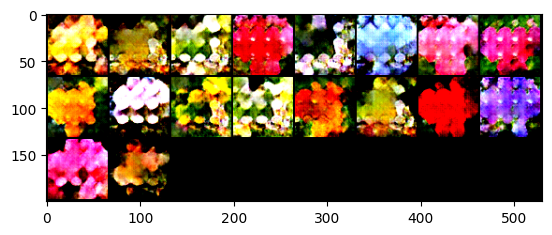

100%|██████████| 103/103 [01:01<00:00,  1.68it/s]


epoch: 12, lossD:1.7557827292136776, lossG:2.6353589377356963,lossG_fake:1.3813932428082216, lossG_real:1.2539656937701031 ,equality:0.12742754903811848


evaluate:123.95751190185547,kid_mean:0.07804758846759796, kid_std:0.03796005621552467,kid_:(tensor(0.0780), tensor(0.0380))


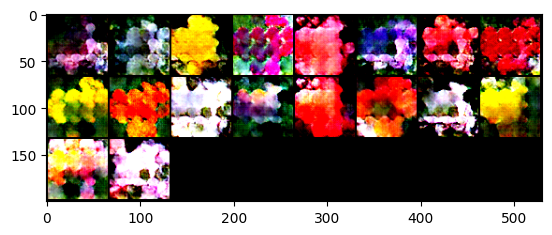

100%|██████████| 103/103 [01:01<00:00,  1.68it/s]


epoch: 13, lossD:1.712484752090232, lossG:2.657682474377086,lossG_fake:1.4017201407441815, lossG_real:1.2559623376837055 ,equality:0.14575780306047603


evaluate:122.32312774658203,kid_mean:0.07877658307552338, kid_std:0.038438957184553146,kid_:(tensor(0.0788), tensor(0.0384))


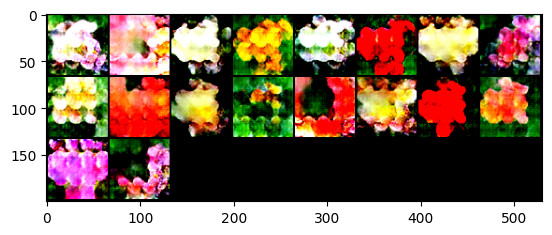

100%|██████████| 103/103 [01:01<00:00,  1.68it/s]


epoch: 14, lossD:1.703677952868267, lossG:2.7274647430308816,lossG_fake:1.427470155132627, lossG_real:1.2999945682229348 ,equality:0.12747558690969218


evaluate:123.25083923339844,kid_mean:0.07264861464500427, kid_std:0.043799396604299545,kid_:(tensor(0.0726), tensor(0.0438))


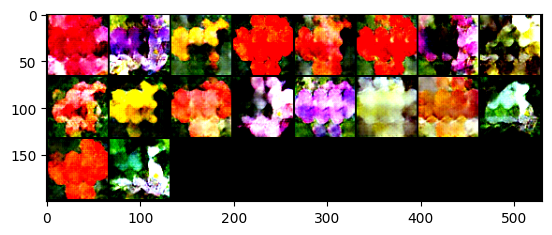

100%|██████████| 103/103 [01:01<00:00,  1.68it/s]


epoch: 15, lossD:1.706216028593119, lossG:2.7345594827411244,lossG_fake:1.4331771447820572, lossG_real:1.3013823269640359 ,equality:0.13179481781802127


evaluate:123.79244232177734,kid_mean:0.07468447834253311, kid_std:0.03882643207907677,kid_:(tensor(0.0747), tensor(0.0388))


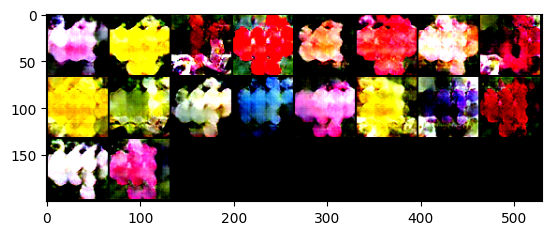

100%|██████████| 103/103 [01:01<00:00,  1.68it/s]


epoch: 16, lossD:1.7839922499888152, lossG:2.684241767068511,lossG_fake:1.394449203338438, lossG_real:1.2897925758824764 ,equality:0.10465662745596149


evaluate:122.0597915649414,kid_mean:0.07163924723863602, kid_std:0.03620800003409386,kid_:(tensor(0.0716), tensor(0.0362))


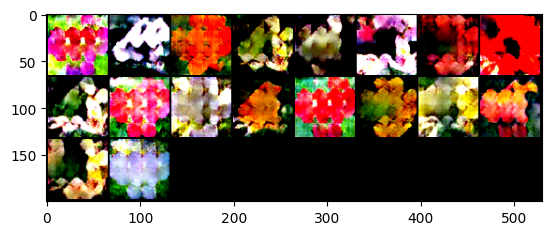

100%|██████████| 103/103 [01:01<00:00,  1.68it/s]


epoch: 17, lossD:1.683834649984119, lossG:2.781324064847335,lossG_fake:1.4443115048038149, lossG_real:1.3370125490484885 ,equality:0.10729895575532633


evaluate:123.68904113769531,kid_mean:0.074910968542099, kid_std:0.040007829666137695,kid_:(tensor(0.0749), tensor(0.0400))


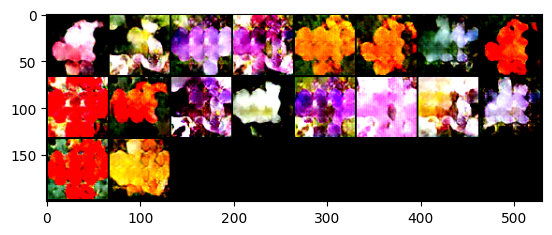

100%|██████████| 103/103 [01:01<00:00,  1.68it/s]


epoch: 18, lossD:1.653895179044853, lossG:2.8236349068799065,lossG_fake:1.4746567028240092, lossG_real:1.348978205213269 ,equality:0.12567849761074013


evaluate:121.60997772216797,kid_mean:0.079254150390625, kid_std:0.038718950003385544,kid_:(tensor(0.0793), tensor(0.0387))


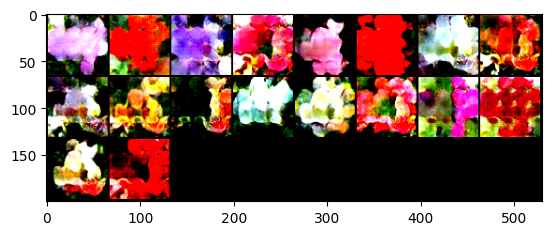

100%|██████████| 103/103 [01:01<00:00,  1.68it/s]


epoch: 19, lossD:1.667840654410205, lossG:2.857013040375941,lossG_fake:1.4933740670241198, lossG_real:1.363638969879706 ,equality:0.12973509714441378


evaluate:121.24859619140625,kid_mean:0.07527098804712296, kid_std:0.04111522063612938,kid_:(tensor(0.0753), tensor(0.0411))


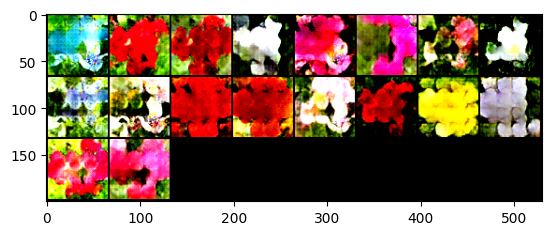

100%|██████████| 103/103 [01:01<00:00,  1.68it/s]


epoch: 20, lossD:1.6284380572513468, lossG:2.9164246054528986,lossG_fake:1.5332292989619727, lossG_real:1.3831953157499 ,equality:0.15003398321207273


evaluate:120.36019897460938,kid_mean:0.07452164590358734, kid_std:0.03866525739431381,kid_:(tensor(0.0745), tensor(0.0387))


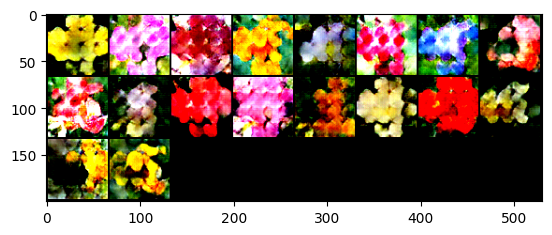

100%|██████████| 103/103 [01:01<00:00,  1.68it/s]


epoch: 21, lossD:1.5998801652667591, lossG:2.968060021261567,lossG_fake:1.5433422784203465, lossG_real:1.4247177468920218 ,equality:0.11862453152832475


evaluate:120.20266723632812,kid_mean:0.07397490739822388, kid_std:0.038676150143146515,kid_:(tensor(0.0740), tensor(0.0387))


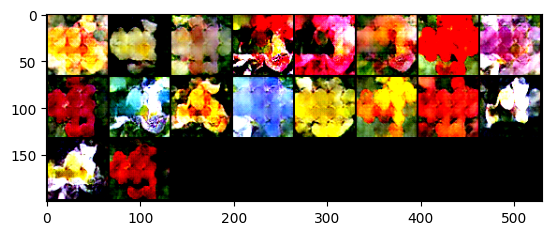

100%|██████████| 103/103 [01:01<00:00,  1.68it/s]


epoch: 22, lossD:1.5470250196827269, lossG:3.067577068088124,lossG_fake:1.5918747423921975, lossG_real:1.4757023390057018 ,equality:0.1161724033864957


evaluate:118.6333999633789,kid_mean:0.07337377220392227, kid_std:0.03532093018293381,kid_:(tensor(0.0734), tensor(0.0353))


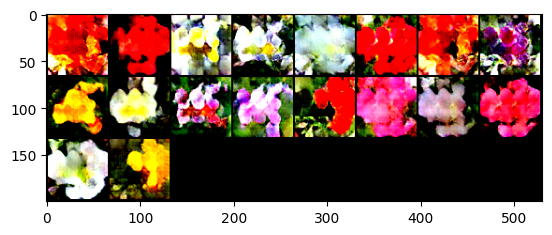

100%|██████████| 103/103 [01:01<00:00,  1.69it/s]


epoch: 23, lossD:1.5031538449444817, lossG:3.1180927082172873,lossG_fake:1.6270216171023915, lossG_real:1.491071100952556 ,equality:0.13595051614983555


evaluate:116.95281219482422,kid_mean:0.08143758773803711, kid_std:0.040477972477674484,kid_:(tensor(0.0814), tensor(0.0405))


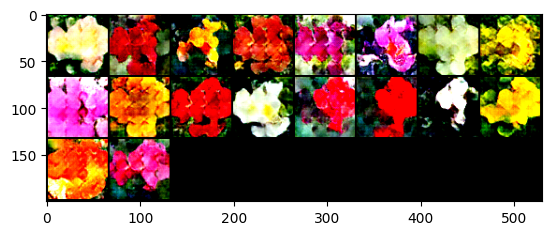

100%|██████████| 103/103 [01:01<00:00,  1.68it/s]


epoch: 24, lossD:1.5088893614926384, lossG:3.1548103314001583,lossG_fake:1.643959740990574, lossG_real:1.5108506002472442 ,equality:0.1331091407433298


evaluate:118.19197082519531,kid_mean:0.07176326960325241, kid_std:0.03949328884482384,kid_:(tensor(0.0718), tensor(0.0395))


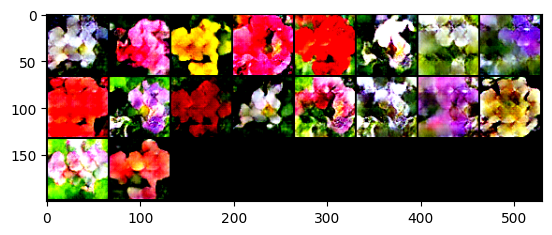

100%|██████████| 103/103 [01:01<00:00,  1.68it/s]


epoch: 25, lossD:1.4541864094224948, lossG:3.258277362990148,lossG_fake:1.7034828211497335, lossG_real:1.5547945563075611 ,equality:0.14868826484217235


evaluate:120.3785400390625,kid_mean:0.07612957805395126, kid_std:0.03747953474521637,kid_:(tensor(0.0761), tensor(0.0375))


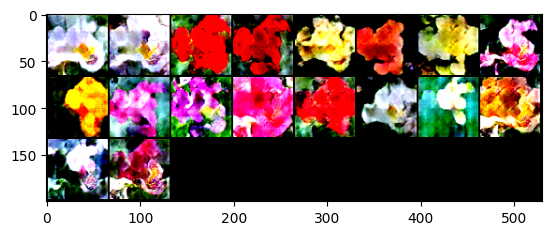

100%|██████████| 103/103 [01:01<00:00,  1.68it/s]


epoch: 26, lossD:1.444978767228358, lossG:3.305864817887834,lossG_fake:1.7083485028118763, lossG_real:1.5975163144972717 ,equality:0.11083218831460462


evaluate:120.7537612915039,kid_mean:0.07999897003173828, kid_std:0.03939419239759445,kid_:(tensor(0.0800), tensor(0.0394))


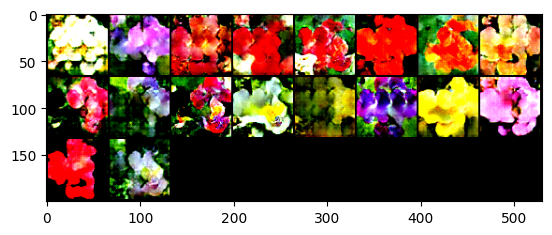

100%|██████████| 103/103 [01:01<00:00,  1.68it/s]


epoch: 27, lossD:1.392336468094761, lossG:3.3507869336211566,lossG_fake:1.7192635883405372, lossG_real:1.63152335222485 ,equality:0.08774023611568715


evaluate:120.1984634399414,kid_mean:0.07168352603912354, kid_std:0.03580866754055023,kid_:(tensor(0.0717), tensor(0.0358))


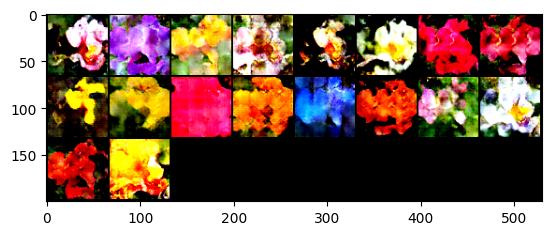

100%|██████████| 103/103 [01:01<00:00,  1.68it/s]


epoch: 28, lossD:1.3697221834682725, lossG:3.3803478120600134,lossG_fake:1.7461000530465136, lossG_real:1.6342477595921858 ,equality:0.11185229345432779


evaluate:122.50292205810547,kid_mean:0.0745328813791275, kid_std:0.036872006952762604,kid_:(tensor(0.0745), tensor(0.0369))


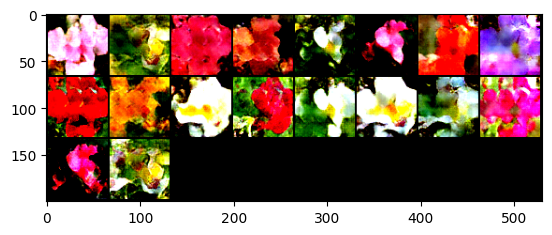

100%|██████████| 103/103 [01:01<00:00,  1.68it/s]


epoch: 29, lossD:1.31106370513879, lossG:3.5140812119233957,lossG_fake:1.829120446756048, lossG_real:1.684960758223117 ,equality:0.14415968853293104


evaluate:122.84662628173828,kid_mean:0.08307723701000214, kid_std:0.043825987726449966,kid_:(tensor(0.0831), tensor(0.0438))


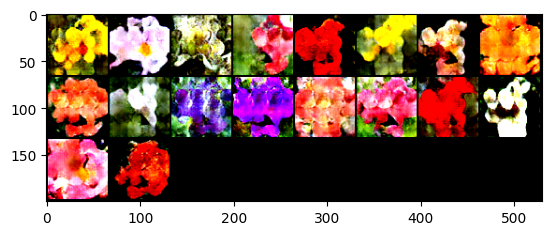

100%|██████████| 103/103 [01:01<00:00,  1.68it/s]


epoch: 30, lossD:1.2683982206779776, lossG:3.653141361995808,lossG_fake:1.8824337807673852, lossG_real:1.7707075800710512 ,equality:0.11172620069633399


evaluate:123.01883697509766,kid_mean:0.07535170763731003, kid_std:0.03672771155834198,kid_:(tensor(0.0754), tensor(0.0367))


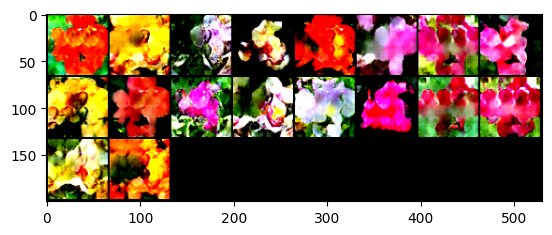

100%|██████████| 103/103 [01:01<00:00,  1.68it/s]


epoch: 31, lossD:1.2218145427194613, lossG:3.745503059868674,lossG_fake:1.9240546735745032, lossG_real:1.8214483724057096 ,equality:0.10260630116879366


evaluate:123.13611602783203,kid_mean:0.08099576085805893, kid_std:0.038776788860559464,kid_:(tensor(0.0810), tensor(0.0388))


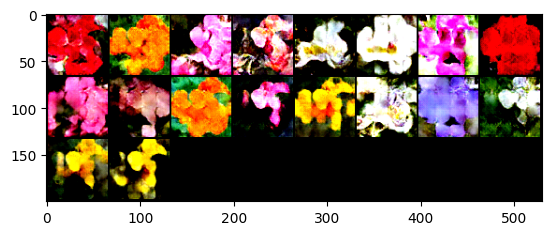

100%|██████████| 103/103 [01:01<00:00,  1.68it/s]


epoch: 32, lossD:1.188430982596666, lossG:3.739141839221843,lossG_fake:1.9386415388977642, lossG_real:1.8005003153699115 ,equality:0.13814122352785274


evaluate:122.62576293945312,kid_mean:0.07270713150501251, kid_std:0.03698863089084625,kid_:(tensor(0.0727), tensor(0.0370))


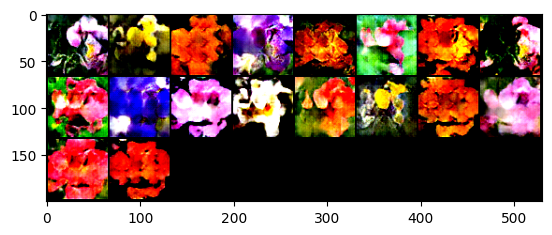

100%|██████████| 103/103 [01:01<00:00,  1.68it/s]


epoch: 33, lossD:1.1250128717098422, lossG:3.865302111338643,lossG_fake:1.996789668948905, lossG_real:1.8685124406536806 ,equality:0.12827722829522448


evaluate:117.45167541503906,kid_mean:0.07785903662443161, kid_std:0.04371558502316475,kid_:(tensor(0.0779), tensor(0.0437))


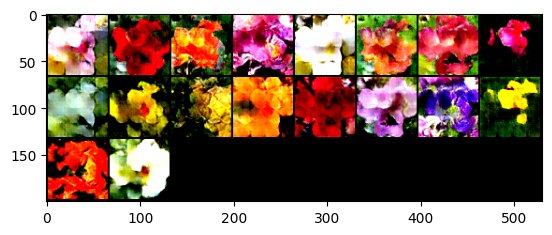

100%|██████████| 103/103 [01:01<00:00,  1.68it/s]


epoch: 34, lossD:1.1091596802461494, lossG:3.98223524417692,lossG_fake:2.0411359175895023, lossG_real:1.9410993208005591 ,equality:0.10003659678894317


evaluate:117.47283935546875,kid_mean:0.08698251843452454, kid_std:0.04026930406689644,kid_:(tensor(0.0870), tensor(0.0403))


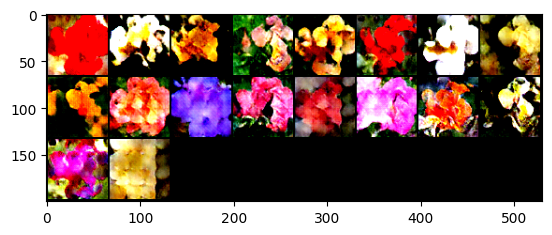

100%|██████████| 103/103 [01:01<00:00,  1.68it/s]


epoch: 35, lossD:1.0373672973183752, lossG:4.052249989463288,lossG_fake:2.083603957324352, lossG_real:1.9686460240373334 ,equality:0.11495793328701853


evaluate:116.48933410644531,kid_mean:0.07239242643117905, kid_std:0.04157958924770355,kid_:(tensor(0.0724), tensor(0.0416))


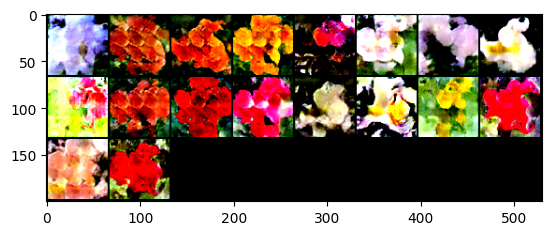

100%|██████████| 103/103 [01:01<00:00,  1.68it/s]


epoch: 36, lossD:0.9786178779254839, lossG:4.220079806244489,lossG_fake:2.168495662004045, lossG_real:2.0515841592862767 ,equality:0.11691150271776829


evaluate:116.76763153076172,kid_mean:0.08079256862401962, kid_std:0.0424518883228302,kid_:(tensor(0.0808), tensor(0.0425))


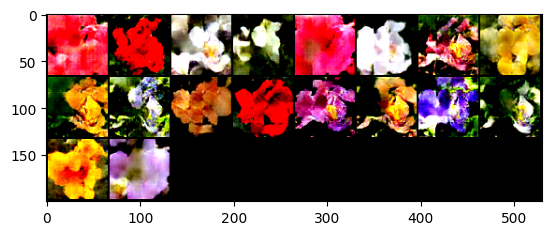

100%|██████████| 103/103 [01:01<00:00,  1.68it/s]


epoch: 37, lossD:0.9290622264436148, lossG:4.322894651912948,lossG_fake:2.181120168815539, lossG_real:2.141774487148211 ,equality:0.03934568166732788


evaluate:116.36061096191406,kid_mean:0.08076559007167816, kid_std:0.0407535657286644,kid_:(tensor(0.0808), tensor(0.0408))


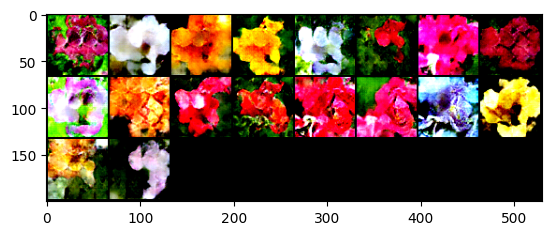

100%|██████████| 103/103 [01:01<00:00,  1.68it/s]


epoch: 38, lossD:0.8835518255974483, lossG:4.425482874935113,lossG_fake:2.2649000935184147, lossG_real:2.1605827906756727 ,equality:0.10431730284274199


evaluate:117.57083892822266,kid_mean:0.07912424206733704, kid_std:0.035476163029670715,kid_:(tensor(0.0791), tensor(0.0355))


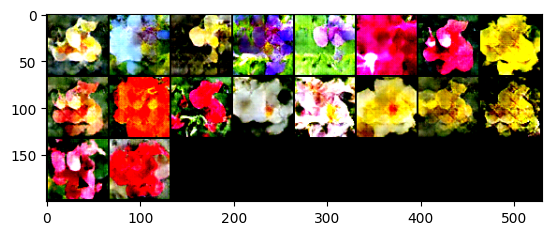

100%|██████████| 103/103 [01:01<00:00,  1.68it/s]


epoch: 39, lossD:0.85356636099445, lossG:4.503569762683609,lossG_fake:2.3139356941852753, lossG_real:2.189634063290161 ,equality:0.12430163089511437


evaluate:117.42832946777344,kid_mean:0.07791956514120102, kid_std:0.04141310229897499,kid_:(tensor(0.0779), tensor(0.0414))


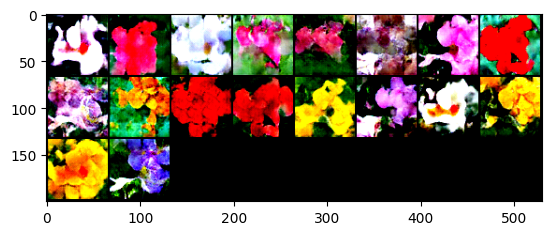

100%|██████████| 103/103 [01:01<00:00,  1.68it/s]


epoch: 40, lossD:0.7946557272406458, lossG:4.628988886342465,lossG_fake:2.348174629859554, lossG_real:2.2808142697926863 ,equality:0.06736036006686774


evaluate:117.0344467163086,kid_mean:0.08027556538581848, kid_std:0.04139482229948044,kid_:(tensor(0.0803), tensor(0.0414))


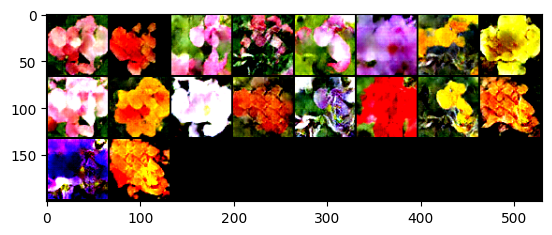

100%|██████████| 103/103 [01:01<00:00,  1.68it/s]


epoch: 41, lossD:0.7603828418023378, lossG:4.702722993869226,lossG_fake:2.4148243642547755, lossG_real:2.2878986463963407 ,equality:0.12692571785843487


evaluate:116.99405670166016,kid_mean:0.08452055603265762, kid_std:0.041894201189279556,kid_:(tensor(0.0845), tensor(0.0419))


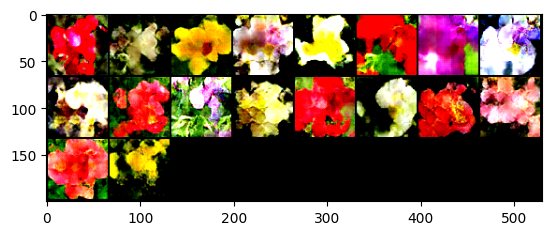

100%|██████████| 103/103 [01:01<00:00,  1.68it/s]


epoch: 42, lossD:0.7072620329636972, lossG:4.802034130374205,lossG_fake:2.3958527156450216, lossG_real:2.4061814390339897 ,equality:-0.010328723388968175


evaluate:116.8000259399414,kid_mean:0.07418185472488403, kid_std:0.034880999475717545,kid_:(tensor(0.0742), tensor(0.0349))


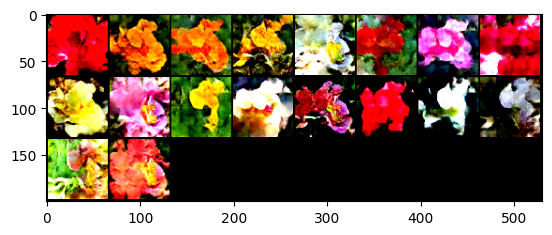

100%|██████████| 103/103 [01:01<00:00,  1.68it/s]


epoch: 43, lossD:0.7833141350341075, lossG:4.734839038941467,lossG_fake:2.386910639920281, lossG_real:2.3479283828179813 ,equality:0.038982257102299744


evaluate:116.90159606933594,kid_mean:0.08161322772502899, kid_std:0.044468775391578674,kid_:(tensor(0.0816), tensor(0.0445))


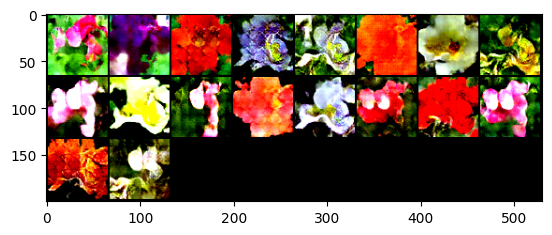

100%|██████████| 103/103 [01:01<00:00,  1.68it/s]


epoch: 44, lossD:0.5978678210267743, lossG:4.94741425930875,lossG_fake:2.4861672700030133, lossG_real:2.4612470263416326 ,equality:0.02492024366138068


evaluate:117.29313659667969,kid_mean:0.07449907809495926, kid_std:0.041878264397382736,kid_:(tensor(0.0745), tensor(0.0419))


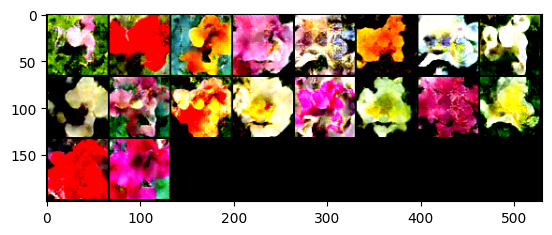

100%|██████████| 103/103 [01:01<00:00,  1.68it/s]


epoch: 45, lossD:0.6339656175340264, lossG:5.070236631967489,lossG_fake:2.5545390774902788, lossG_real:2.515697523228173 ,equality:0.03884155426210567


evaluate:117.1883773803711,kid_mean:0.08248323202133179, kid_std:0.04701003432273865,kid_:(tensor(0.0825), tensor(0.0470))


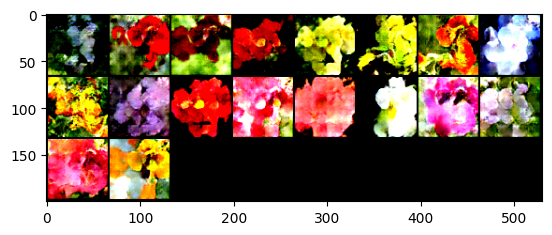

100%|██████████| 103/103 [01:01<00:00,  1.68it/s]


epoch: 46, lossD:0.5658156897836518, lossG:5.195148940225249,lossG_fake:2.6447924624368984, lossG_real:2.5503564991997285 ,equality:0.09443596323716985


evaluate:116.84003448486328,kid_mean:0.08118905127048492, kid_std:0.04227082058787346,kid_:(tensor(0.0812), tensor(0.0423))


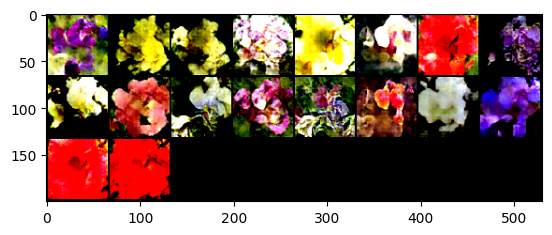

100%|██████████| 103/103 [01:01<00:00,  1.68it/s]


epoch: 47, lossD:0.524443995243716, lossG:5.288892111731965,lossG_fake:2.6802354975811484, lossG_real:2.6086566390343084 ,equality:0.07157885854683999


evaluate:116.43458557128906,kid_mean:0.07406117767095566, kid_std:0.03916631639003754,kid_:(tensor(0.0741), tensor(0.0392))


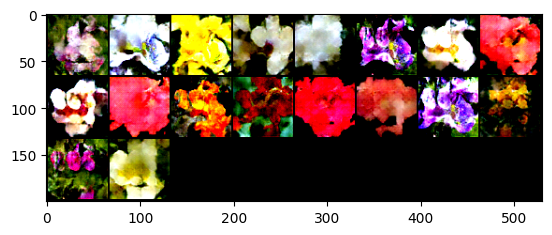

100%|██████████| 103/103 [01:01<00:00,  1.68it/s]


epoch: 48, lossD:0.5509279695818725, lossG:5.3917049065376945,lossG_fake:2.690189941994195, lossG_real:2.701514968594301 ,equality:-0.01132502660010637


evaluate:116.36658477783203,kid_mean:0.0752444863319397, kid_std:0.03925551474094391,kid_:(tensor(0.0752), tensor(0.0393))


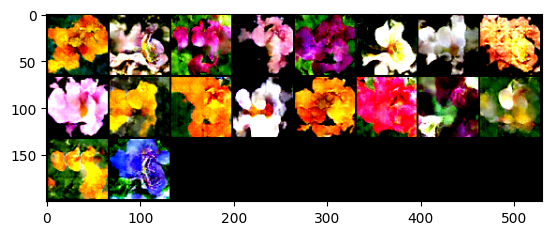

100%|██████████| 103/103 [01:01<00:00,  1.68it/s]


epoch: 49, lossD:0.637958264538964, lossG:5.397031177594823,lossG_fake:2.6896965631003518, lossG_real:2.7073346335911057 ,equality:-0.017638070490753943


evaluate:115.54651641845703,kid_mean:0.08113069832324982, kid_std:0.04701079800724983,kid_:(tensor(0.0811), tensor(0.0470))


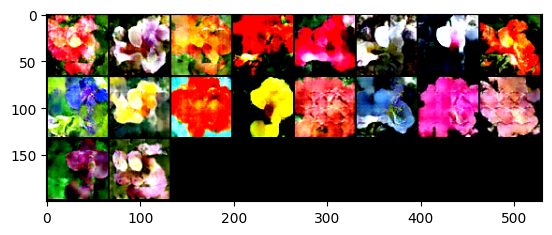

In [44]:
lossesD = []
lossesG = []

raw_lossesD = []
raw_lossesG = []
lossesG_fake = []
lossesG_real = []

equality = 0.0
sum_equality = 0.0
d_equality = []

relu = torch.nn.ReLU()

fid_ = []
kid_mean_ = []
kid_std_ = []
kid_score = []
for epoch in range(opt.n_epoch):
    running_lossD = 0.0 #損失関数初期化
    running_lossG = 0.0
    lossG_fake_running = 0.0
    lossG_real_running = 0.0

    #sum_equality += equality
    equality = 0.0
   # for i , (real_imgs, _) in enumerate(tqdm.tqdm(dataloader, position = 0)):#celebA
    for i , real_imgs in enumerate(tqdm.tqdm(dataloader, position = 0)):#flower
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size()[0]
        noise = torch.randn(batch_size, opt.z_dim, 1, 1).to(device)

        #train discriminator

        netD.zero_grad()
        output_real = netD(real_imgs)

        #lossD_real = criterion(output, labels_real)
        lossD_real = torch.mean(relu(1.0 - output_real))


        fake_imgs = netG(noise)##not train  output_fake_d
        output_fake_d = netD(fake_imgs.detach())#not train  output_fake_d

        #lossD_fake = criterion(output, labels_fake)
        lossD_fake = torch.mean(relu(1.0 + output_fake_d))


        lossD = lossD_real + lossD_fake
        #lossD = torch.mean(torch.log(torch.sigmoid(output_real)))- torch.mean(torch.log(torch.sigmoid(output_fake_d)))  #not train  output_fake_d
        lossD.backward()
        optimizerD.step()

        #train generator

        netG.zero_grad()#勾配初期

        output_fake_g = netD(fake_imgs)#train  output_fake_g
        output_real = netD(real_imgs)

        lossG_fake = torch.mean(relu(1.0 - output_fake_g))
        lossG_real = torch.mean(relu(1.0 + output_real))
        #lossG =  torch.mean(torch.log(torch.sigmoid(output_fake_g - output_real))) #- torch.mean(torch.log(torch.sigmoid(output_real)))#train  output_fake_g
        lossG =    lossG_real + lossG_fake


        lossG.backward()
        optimizerG.step()

        # save loss

        running_lossD += lossD.item()
        running_lossG += lossG.item()

        raw_lossesD.append(lossD.item())
        raw_lossesG.append(lossG.item())

        lossG_fake_running += lossG_fake.item()
        lossG_real_running += lossG_real.item()



    running_lossD /=len(dataloader)
    running_lossG /=len(dataloader)

    lossG_fake_running /= len(dataloader)
    lossG_real_running /= len(dataloader)
#equality
    equality = ( lossG_fake_running - lossG_real_running  )
    d_equality.append(equality)


    print("epoch: {}, lossD:{}, lossG:{},lossG_fake:{}, lossG_real:{} ,equality:{}".format(epoch, running_lossD, running_lossG,lossG_fake_running,lossG_real_running,equality))#-->,lossG_fake:{}, lossG_real:{},lossG_fake_running,lossG_real_running
    lossesD.append(running_lossD)
    lossesG.append(running_lossG)

    lossesG_fake.append(lossG_fake_running)
    lossesG_real.append(lossG_real_running)

     #evaluate GAN
    fake_imgs_1 = fake_imgs.detach()
    real_imgs_1 = real_imgs.to(dtype=torch.uint8).cpu()
    fake_imgs_1 = fake_imgs_1.to(dtype=torch.uint8).cpu()
    fid.update(real_imgs_1, real=True)
    fid.update(fake_imgs_1, real=False)
    eval = fid.compute()

    kid.update(real_imgs_1, real=True)
    kid.update(fake_imgs_1, real=False)
    kid_ = kid.compute()
    kid_mean, kid_std = kid.compute()



    print("evaluate:{},kid_mean:{}, kid_std:{},kid_:{}".format(eval, kid_mean, kid_std, kid_))
    fid_.append(eval)
    kid_mean_.append(kid_mean)
    kid_std_.append(kid_std)
    kid_score.append(kid_)
    #show fake image
    grid_imgs = vutils.make_grid(fake_imgs[:24].detach()+0.5)
    grid_imgs_arr = grid_imgs.cpu().numpy()
    plt.imshow(np.transpose(grid_imgs_arr, (1,2,0)))
    plt.show()

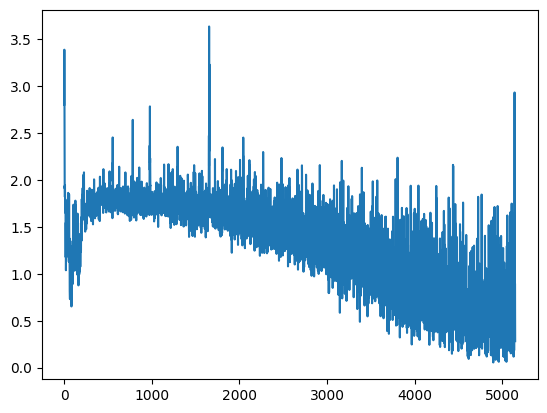

In [45]:
plt.plot(raw_lossesD)

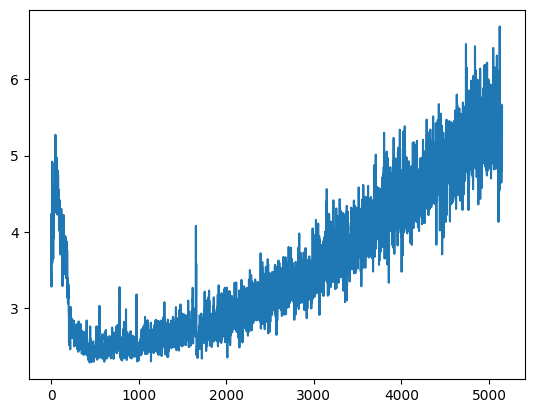

In [46]:
plt.plot(raw_lossesG)

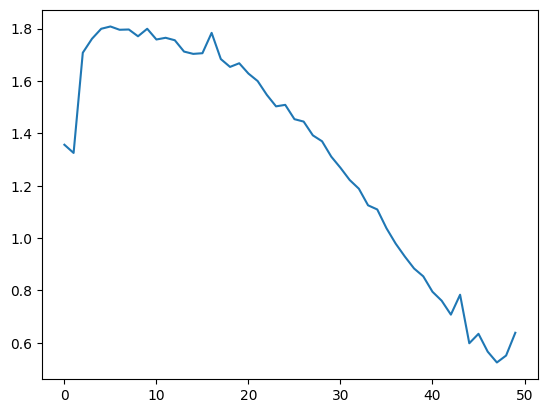

In [47]:
plt.plot(lossesD)

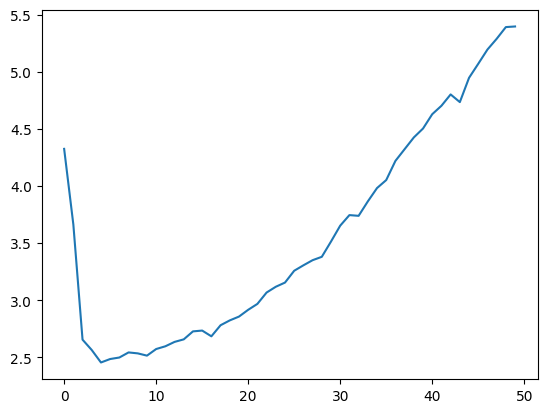

In [48]:
plt.plot(lossesG)

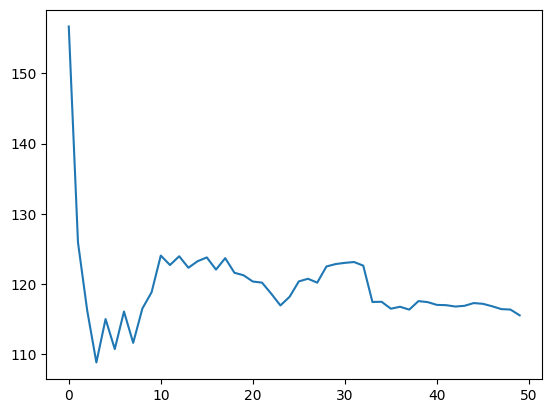

In [49]:
plt.plot(fid_)

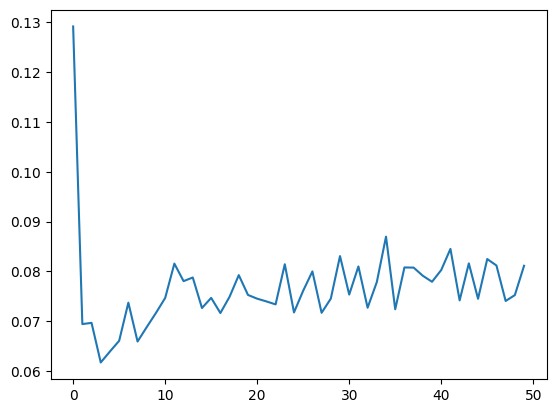

In [50]:
plt.plot(kid_mean_)

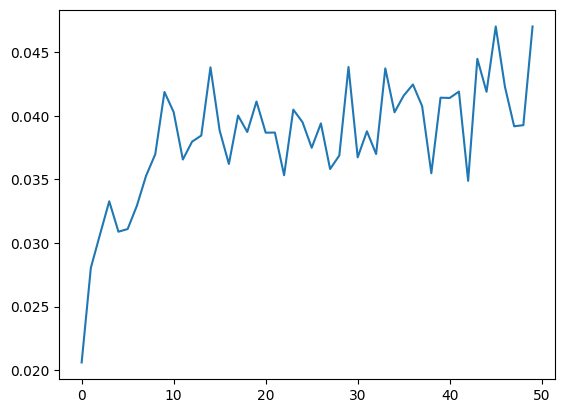

In [51]:
plt.plot(kid_std_)

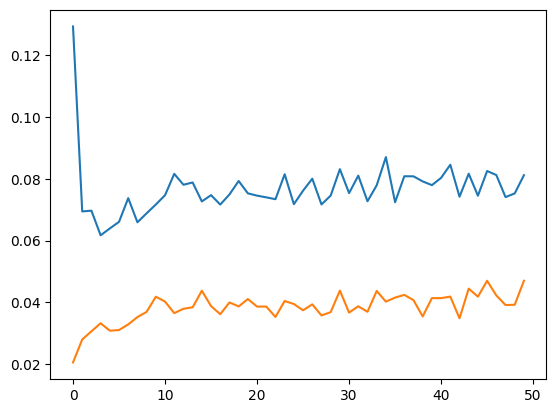

In [52]:
plt.plot(kid_score)

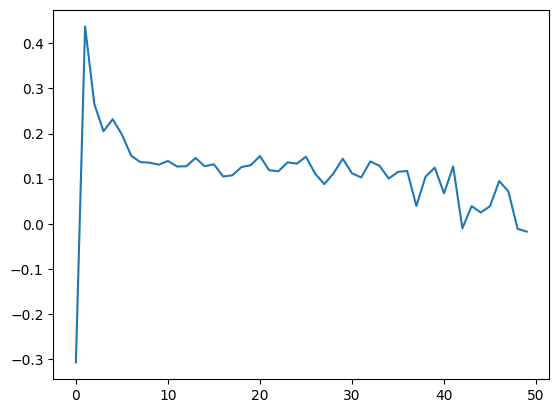

In [53]:
plt.plot(d_equality)

In [54]:

import torch
!pip install torcheval


from torcheval.metrics import PeakSignalNoiseRatio
import torch
import torchvision
#from torcheval.metrics import StructuralSimilarity

real_imgs = real_imgs.to(dtype=torch.uint8).cpu()
fake_imgs = fake_imgs.to(dtype=torch.uint8).cpu()
fid.update(real_imgs, real=True)
fid.update(fake_imgs, real=False)
print(f'fid ',fid.compute())

kid.update(real_imgs, real=True)
kid.update(fake_imgs, real=False)
print(f'kid ',kid.compute())

metric = PeakSignalNoiseRatio()
#input = torch.tensor([[0.1, 0.2], [0.3, 0.4]])
#>>> target = input * 0.9
metric.update(fake_imgs,real_imgs)
print(f'PSNR',metric.compute())#高いほどいい
#PSNR (Peak Signal-to-Noise Ratio): PSNRは、生成画像と本物の画像の間のノイズの量を測定します。高いPSNRは、より低いノイズレベルを示します。

import torch
from skimage.metrics import structural_similarity as ssim
import numpy as np

# 例えば、real_imageが与えられているとします
real_image =real_imgs # 仮のランダムな画像データ
fake_image =fake_imgs
# PyTorch TensorをNumPy配列に変換
real_image_np = real_image.cpu().numpy()

# SSIMを計算するために、0から1の範囲に正規化することが推奨されます
real_image_np = np.clip((real_image_np + 1) / 2.0, 0, 1)

# PyTorch TensorをNumPy配列に変換
fake_image_np = fake_image.cpu().numpy()

# SSIMを計算するために、0から1の範囲に正規化することが推奨されます
fake_image_np = np.clip((fake_image_np + 1) / 2.0, 0, 1)

# SSIMを計算
ssim_value = ssim(real_image_np[0], fake_image_np[0], win_size=3)
print(f"SSIM値: {ssim_value}")
#SSIMは、画像の品質を評価するための指標であり、生成画像と本物の画像の構造的な類似性を測定します。1に近い値が高い品質を示します。

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 3.3 MB/s eta 0:00:00
fid  tensor(114.7591)
kid  (tensor(0.0739), tensor(0.0418))
PSNR tensor(75.2135)
SSIM値: 0.9871413388276754
